# Importing Libraries

In [87]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score, log_loss, classification_report
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from hyperopt import hp, tpe, fmin, Trials, space_eval
import warnings
import shap
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from Functions_George import read_txt_file

# Importing Data and clipping the "bad" looking ones

In [88]:
Data = pd.read_csv('features.csv')

path1, path2 = 'ctrl_dis.txt', 'pntr_dis.txt'
Control_dis, Drug_dis = read_txt_file(path1), read_txt_file(path2)

First_damaged = Data[Data['label'] == 1].index[0]

Indices_to_discard = Control_dis + [x + First_damaged for x in Drug_dis]
Data = Data.drop(Indices_to_discard, axis = 0)

###Check for NaN's###
if Data.isnull().any().any():
    raise ValueError("DataFrame contains at least one NaN value")

print('Got',len(Data),'entries')

Got 2040 entries


# Splitting the Data into train, validation and test sets
# and training a Classifier to determine the importances

In [89]:
X = Data.drop(['label'], axis=1)
y = Data['label']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data into training and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)


RF_model = RandomForestClassifier(random_state=42, max_depth=8, criterion='log_loss', n_estimators=300, n_jobs = -1)
RF_model.fit(X_train, y_train)

y_pred_proba = RF_model.predict_proba(X_val)[:, 1]

# Step 6: Evaluate the model
accuracy = accuracy_score(y_val, y_pred_proba.round())
conf_matrix = confusion_matrix(y_val, y_pred_proba.round())
logloss = log_loss(y_val, y_pred_proba)

print('On the Validation set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])
print("Classification Report:\n", classification_report(y_val, y_pred_proba.round()))

y_pred_proba = RF_model.predict_proba(X_test)[:, 1]

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)

print('On the Validation set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])
print("Classification Report:\n", classification_report(y_test, y_pred_proba.round()))

On the Validation set:

Accuracy: 0.8315217391304348
LogLoss: 0.41560453016596655
Confusion matrix: [78  9] 
                  [22 75]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.83        87
           1       0.89      0.77      0.83        97

    accuracy                           0.83       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.83      0.83       184

On the Validation set:

Accuracy: 0.8333333333333334
LogLoss: 0.395015605053814
Confusion matrix: [92 12] 
                  [22 78]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       104
           1       0.87      0.78      0.82       100

    accuracy                           0.83       204
   macro avg       0.84      0.83      0.83       204
weighted avg       0.84      0.83      0.83       204



# 20 most important features using RandomForest's feature importance

In [90]:
importances = RF_model.feature_importances_
sorted_indices = importances.argsort()[::-1]
top_features = X.columns[sorted_indices[:20]]

top_features_df = pd.DataFrame({'Top Features based on feature importances': top_features}, index=range(1, len(top_features) + 1))
display(top_features_df)

,Top Features based on feature importances
1,getNucleusMinR
2,getEdgeFluxR
3,getAreaOfHoles
4,getEntropyR
5,getH8R
6,getEntropyB
7,getCellMinR
8,getH3R
9,getNHoles
10,getH2R


# Correlation matrix of the most important features

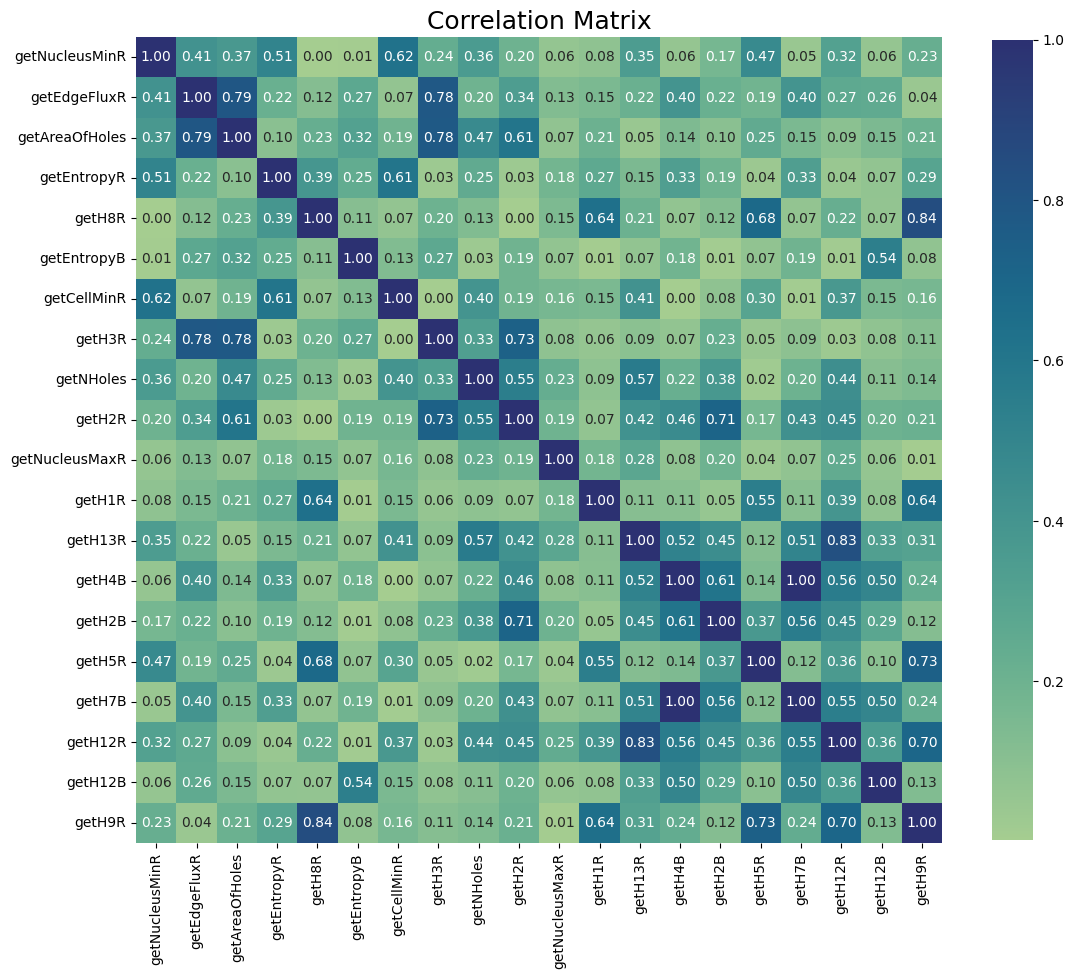

In [91]:
X_top_features = X[top_features]
correlation_matrix = X_top_features.corr()

###UNCOMMENT FOR SPEARMAN METHOD####
# correlation_matrix = X_top_features.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (13,13))
sns.heatmap(np.abs(correlation_matrix), annot = True, cmap = 'crest', square = True, fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

# Hyperparameter search (Bayes optimization) with Cross-Validation

In [92]:
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 3000, 50, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 30, dtype=int)),
    'min_samples_split': hp.uniform('min_samples_split', 0.0, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.0, 1.0),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'max_samples': hp.uniform('max_samples', 0.0, 1.0),
}

def objective(params):
    model = RandomForestClassifier(random_state=42, criterion = 'log_loss', **params, n_jobs=-1)
    scores = cross_val_score(model, X_train_val, y_train_val, cv=6, scoring='neg_log_loss')
    return -np.mean(scores)

trials = Trials()
start_time = time.time()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
end_time = time.time()

best_params = space_eval(space, best)
print("Best Hyperparameters:", best_params)

elapsed_time = end_time - start_time
print("Elapsed time of Bayesian optimization:", elapsed_time, "seconds \n")

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [13:17<00:00, 15.95s/trial, best loss: 0.4127825509222274] 
Best Hyperparameters: {'max_depth': 19, 'max_features': None, 'max_samples': 0.8809316516655988, 'min_samples_leaf': 0.008283602173304714, 'min_samples_split': 0.048047264915365984, 'n_estimators': 2400}
Elapsed time of Bayesian optimization: 797.6435055732727 seconds 



# Testing on the Validation data by training on the Train data

In [93]:
from sklearn.model_selection import KFold

best_model = RandomForestClassifier(criterion='log_loss', **best_params, n_jobs=-1)

kf = KFold(n_splits=6, shuffle=True, random_state=42)

val_logloss_scores = []
val_accuracy_scores = []

start_time = time.time()

for train_index, val_index in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    best_model.fit(X_train, y_train)
    
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    val_logloss = log_loss(y_val, y_pred_proba)
    val_accuracy = accuracy_score(y_val, y_pred_proba.round())

    val_logloss_scores.append(val_logloss)
    val_accuracy_scores.append(val_accuracy)
    
end_time = time.time()

mean_logloss = np.mean(val_logloss_scores)
mean_accuracy = np.mean(val_accuracy_scores)

print("Mean LogLoss from Cross-Validation:", mean_logloss)
print("Mean Accuracy from Cross-Validation:", mean_accuracy)

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds \n")

Mean LogLoss from Cross-Validation: 0.41298533008160065
Mean Accuracy from Cross-Validation: 0.8022875816993463
Elapsed time: 60.68064737319946 seconds 



# Testing on the Test data by training on both the Train and Validation data

In [94]:
best_model.fit(X_train_val, y_train_val)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)

print(f'On the Test set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])

On the Test set:

Accuracy: 0.8382352941176471
LogLoss: 0.3841857521664697
Confusion matrix: [90 14] 
                  [19 81]
